Hi All,  
thank you for visiting my kernel. I am beginner in Python programming and specially in data science. So I would be very keen if you could make some comments providing me some tips to be a better. Enjoy:-)

In [1]:
import numpy as np
import pandas as pd

Let's import train and test datasets:

In [2]:
dfTrain = pd.read_csv("../input/train.csv") # importing train dataset
dfTest = pd.read_csv("../input/test.csv") # importing test dataset

Let's check what is inside:

In [3]:
dfTrain.head(1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
PassengerId    1 non-null int64
Survived       1 non-null int64
Pclass         1 non-null int64
Name           1 non-null object
Sex            1 non-null object
Age            1 non-null float64
SibSp          1 non-null int64
Parch          1 non-null int64
Ticket         1 non-null object
Fare           1 non-null float64
Cabin          0 non-null object
Embarked       1 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 176.0+ bytes


So for train dataset we have 891 records and 12 columns. Three columns contain some null data:   
Cabin: 687 nulls    
Age: 177 nulls  
Embarked: 2 nulls  
Let's see what is in test dataset:

In [4]:
dfTest.head(1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
PassengerId    1 non-null int64
Pclass         1 non-null int64
Name           1 non-null object
Sex            1 non-null object
Age            1 non-null float64
SibSp          1 non-null int64
Parch          1 non-null int64
Ticket         1 non-null object
Fare           1 non-null float64
Cabin          0 non-null object
Embarked       1 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 168.0+ bytes


Here we have 418 records. So data are split: 2/3 (train) and 1/3 (test).  
Regarding empty records:  
Cabin: 327 nulls  
Age: 86 nulls  
Fare: 1 null  

I want to set index as PassengerId:

In [5]:
dfTrain.set_index(['PassengerId'],inplace=True)
dfTest.set_index(['PassengerId'],inplace=True)

# PART 1: PCLASS

My intuition says that Pclass could have an impact on Survival as higher class may have better access to lifeboats.  
Let's see:

In [6]:
import matplotlib as plt
%matplotlib inline

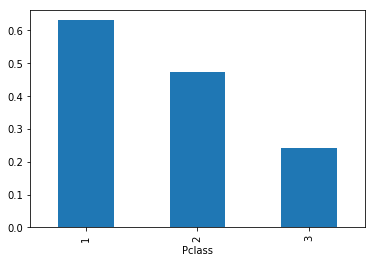

In [7]:
dfTrain.groupby('Pclass').Survived.mean().plot(kind='bar')

That's true. Passengers from 1st class have better chance to survive than from 3rd. Clear correlation.

Now I would like to check what would be the score. I will be using Decision Tree classifer as it is quite easy and ideal for category data.

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

What we did? We fit the model (X_train + y) and then made a prediction using X_test. Then we created csv list ready to upload to Kaggle competition. We submitted the file and the result is:

![Image](http://i63.tinypic.com/2rmv69g.jpg)

Quite nice start. 65% accurracy. I am happy;-)

# PART 2: SEX

What about sex? It could be also reasonable to check it as women should be passed before men:

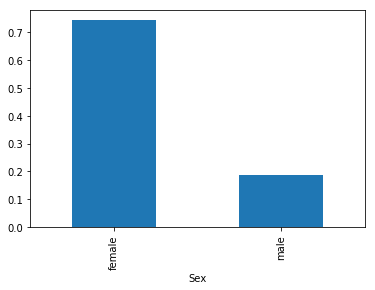

In [10]:
dfTrain.groupby('Sex').Survived.mean().plot(kind='bar')

Wow, what a great correlation!  
Now, I am curious to check what is the survival rate for Class and Sex together:

In [11]:
import seaborn as sns

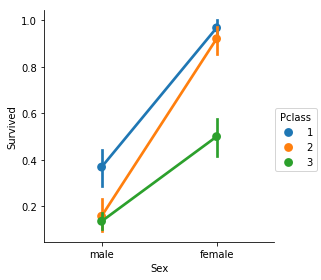

In [12]:
sns.factorplot("Sex", "Survived", hue="Pclass", data=dfTrain)

This is what I expected. Women from 1st and 2nd class had a chance to survive equals almost 100%!  
Respectively men from 2nd and 3rd class had only ~10% chance:-(

Let's predict the result combining Pclass & Sex:

In [13]:
dfFull = pd.concat([dfTrain,dfTest])
dfFull['Sex'] = dfFull['Sex'].map({'male': 0, 'female': 1}).astype(int)
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]

In [14]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](http://i64.tinypic.com/34ot551.jpg)

Wow, what a progress! We gained 10% accurracy addding Sex category. Good direction;-)

# PART 3: PARCH

I wonder now about the Parch. It tells us how many children/parents travel with the passenger. Does it mean that families were priviliged or better to be a single? Let's check it. 

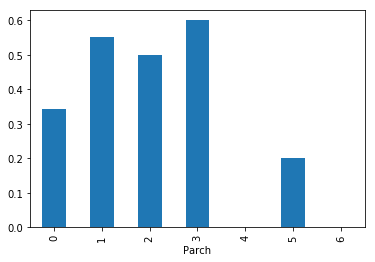

In [15]:
dfTrain.groupby('Parch').Survived.mean().plot(kind='bar')

Excellent. It seams there is a bonus for families, at least no bigger than 4. Singles are penalized. Before we build categories let's check number of items in each group:


In [16]:
dfFull.Parch.value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

Categories with the items less than ~45 can't be taken as representative, so I make the following split:  
0  
1  
2  
3 and more

In [17]:
dfFull['ParchCat'] = dfFull.Parch.copy().astype(int)
dfFull.loc[dfFull.Parch > 2,'ParchCat'] = 3
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]

Let's double check it:

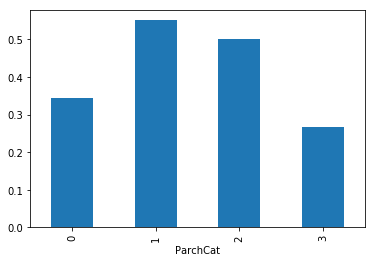

In [18]:
dfTrain.groupby('ParchCat').Survived.mean().plot(kind='bar')

I am curious if adding Parch will improve our result:

In [19]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](http://i63.tinypic.com/154hax1.png)

Slight change in good direction +1% better;-)

# Part 4: SibSp

Naturally, after Parch category, let's check SibSp. It shows number of siblings or spouses.    
The question is, wether there is a correlation to Survival rate?

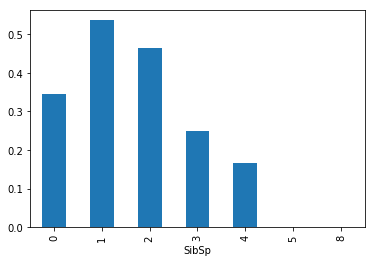

In [20]:
dfTrain.groupby('SibSp').Survived.mean().plot(kind='bar')

OK, similarly to Parch, having small family onboarded gives better chance to survive.  
I want to check how big is each group:

In [21]:
dfFull.SibSp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

Again, categories below 45 items are not respresentative. Let's group them:

In [22]:
dfFull['SibSpCat'] = dfFull.SibSp.copy().astype(int)
dfFull.loc[dfFull.SibSp > 2,'SibSpCat'] = 3
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]

It's time to verify the result:

In [23]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','SibSpCat']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','SibSpCat']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](http://i66.tinypic.com/2v7tf8k.png)

I am disappointed:-( The result is worse than without SibSp. Likely because Parch digested all glory...  
We are removing SibSp from the scope...

# PART 5: EMBARKED

I am not optimistic here as I don't believe that departure place could influence survival rate.  
However, we need to check it:

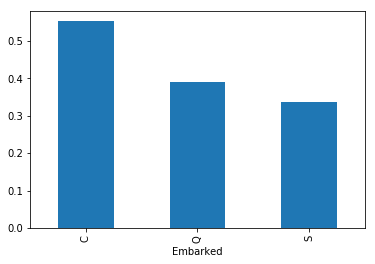

In [24]:
dfTrain.groupby('Embarked').Survived.mean().plot(kind='bar')

Let's recall: C = Cherbourg, Q = Queenstown, S = Southampton  
Wow, I am bit surprised. Maybe in Southampton were more males than in Cherbourg or Southhampton passengers chosen third class?

In [25]:
dfFull.groupby(['Embarked','Sex']).Name.count()

Embarked  Sex
C         0      157
          1      113
Q         0       63
          1       60
S         0      623
          1      291
Name: Name, dtype: int64

In [26]:
dfFull.groupby(['Embarked','Pclass']).Name.count()

Embarked  Pclass
C         1         141
          2          28
          3         101
Q         1           3
          2           7
          3         113
S         1         177
          2         242
          3         495
Name: Name, dtype: int64

Precisly. Cherbourg passengers are mainly first class. Moreover, no big difference between males and females (M:157, F:113).  
Southampton: mainly third class and males twice more the females.  
By the way it is interesting comparing countries:  
Cherbourg: France  
Southampton: England  
Quincetown: Ireland  
It seems that these days, the richest people were in France..

Before we start the prediction we need to imput two empty values:

In [27]:
dfFull[dfFull.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,ParchCat,SibSpCat
PassengerId,,,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,1,0,1.0,113572,0,0
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,1,0,1.0,113572,0,0


Let's presume that Fare and Class are related to Port. Having similar passengers with the comparable fare and class we can predict departure port:  

In [28]:
indexEmbarked = dfFull[dfFull.Embarked.isnull()].index.tolist()
for indEmb in indexEmbarked:
    fareEmbarked = dfFull.loc[indEmb].Fare.mean()
    predictedEmbarked = dfFull[(dfFull.Fare < fareEmbarked*1.1) &
                           (dfFull.Fare > fareEmbarked*0.9) &
                           (dfFull.Pclass == dfFull.loc[indEmb].Pclass)].Embarked.mode()
    dfFull.loc[indEmb,'Embarked'] = predictedEmbarked[0]
    print(predictedEmbarked)   

0    C
dtype: object
0    C
dtype: object


It seems both passengers were onboarded in France. They survived...

Good, we have now all data in Embarked column. Let's make a prediction:

In [29]:
dfFull['Embarked'] = dfFull['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]

In [30]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](http://i68.tinypic.com/162203l.png)

Wow! + 1.5% accurracy. I am suprised!

# PART 6: FARE

Money can't swim, however they may somehow support Class category. Let's verify it:

Firstly, let's fill empty values:

In [31]:
nullFares = dfFull[dfFull.Fare.isnull()].index.values
dfFull.loc[nullFares]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,ParchCat,SibSpCat
PassengerId,,,,,,,,,,,,,
1044,60.5,NaN,0,NaN,"Storey, Mr. Thomas",0,3,0,0,NaN,3701,0,0


In [32]:
dfFull.loc[nullFares,'Fare']
dfFull.loc[nullFares,'Fare'] = dfFull[(dfFull.ParchCat == 0) & (dfFull.Pclass ==3 ) & (dfFull.Embarked == 0)].Fare.mean()
dfFull.loc[[1044]]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,ParchCat,SibSpCat
PassengerId,,,,,,,,,,,,,
1044,60.5,NaN,0,10.118203,"Storey, Mr. Thomas",0,3,0,0,NaN,3701,0,0


We calculated the mean of similar passengers from the same Class, Embarked and ParchCat. Mr Thomas paid ~10 pounds  

Now, let's see the correlance in the graph:

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0,'Fare')

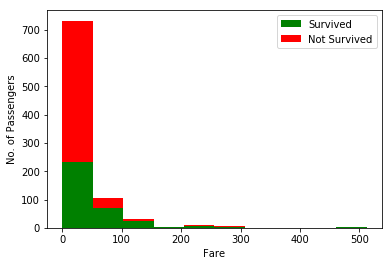

In [33]:
import matplotlib.pyplot as plt
plt.hist([dfTrain[dfTrain['Survived']==1]['Fare'], dfTrain[dfTrain['Survived']==0]['Fare']], stacked=True, color = ['g','r'],
         bins = 10,label = ['Survived','Not Survived'])
plt.legend()
plt.ylabel('No. of Passengers')
plt.xlabel('Fare')

I think it looks obvious that low fares had less chance to survive.  
Let's make a simple split based on mean value:

In [34]:
fareMean = dfFull.Fare.mean()
dfFull.loc[dfFull.Fare <= fareMean,'Fare']=0
dfFull.loc[dfFull.Fare > fareMean,'Fare']=1
dfFull.Fare.value_counts()

0.0    1005
1.0     304
Name: Fare, dtype: int64

And now we are ready to start a prediction:

In [35]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked','Fare']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked','Fare']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](http://i67.tinypic.com/mmsksk.png)

Well done;-) ~+0.5%. We can improve the result providing more fitted split, but let's leave it at this point.

## PART 7: CABIN

Honestly speaking I am not optimistic here. There are a lot of unique values and actually I don't really know what and where the cabin is. Moreover I have a lot of questions here i.e. does it mean, that empty values don't have a cabin or just data are missed? Hmm...

Let's start from some analysis:

In [36]:
dfFull.Cabin.value_counts(dropna=False)

NaN                1014
C23 C25 C27           6
B57 B59 B63 B66       5
G6                    5
C78                   4
C22 C26               4
F4                    4
D                     4
F33                   4
B96 B98               4
F2                    4
A34                   3
B58 B60               3
C101                  3
E101                  3
E34                   3
B51 B53 B55           3
C32                   2
C85                   2
B28                   2
B20                   2
D37                   2
B78                   2
B18                   2
D19                   2
B35                   2
B69                   2
C92                   2
E8                    2
C83                   2
                   ... 
B42                   1
B24                   1
C49                   1
E52                   1
A23                   1
A9                    1
A19                   1
B3                    1
C99                   1
F                     1
A24             

That's a lot of categories. Let's simplify it taking only first letter:

In [37]:
dfFull.Cabin.str[0].value_counts(dropna=False)

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Cabin, dtype: int64

Now it is better. We have to move last two items to N/A and make 'Z' category:

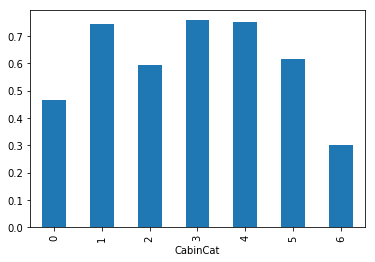

In [38]:
dfFull['CabinCat'] = dfFull.Cabin.str[0].fillna('Z')
dfFull.loc[dfFull.CabinCat=='G','CabinCat']= 'Z'
dfFull.loc[dfFull.CabinCat=='T','CabinCat']= 'Z'
dfFull['CabinCat'] = dfFull['CabinCat'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'Z': 6}).astype(int)
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dfTrain.groupby('CabinCat').Survived.mean().plot(kind='bar')

 I am not sure. Let's predict:

In [39]:
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked','Fare','CabinCat']]
X_train = pd.get_dummies(X_train)
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked','Fare','CabinCat']]
X_test = pd.get_dummies(X_test)
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

### score: 0.77990

The same result as without... No improvement so let's rig it out.

## PART 8: NAME 

Name category is problematic, as only Title seems to be reasonable to take:

In [40]:
dfFull['Title'] = dfFull.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
dfFull.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Mlle          2
Major         2
Mme           1
Capt          1
Jonkheer      1
Sir           1
Dona          1
Lady          1
Don           1
Countess      1
Name: Title, dtype: int64

All small categories should be taken out. We can put them into new category like Rest or something.  
We could also try to impute them putting mean values or... predict it:

In [41]:
dfFull['TitleCat']=dfFull['Title']
dfFull.TitleCat.replace(to_replace=['Rev','Dr','Col','Major','Mlle','Ms','Countess','Capt','Dona','Don','Sir','Lady','Jonkheer','Mme'],
                        value=0, inplace=True)
dfFull.TitleCat.replace('Mr',1,inplace=True)
dfFull.TitleCat.replace('Miss',2,inplace=True)
dfFull.TitleCat.replace('Mrs',3,inplace=True)
dfFull.TitleCat.replace('Master',4,inplace=True)                                            
dfFull.TitleCat.value_counts(dropna=False)

1    757
2    260
3    197
4     61
0     34
Name: TitleCat, dtype: int64

Firstly let's check what categories could have an impact on Title by building correlation matrix:

In [42]:
dfFull.corr().TitleCat

Age        -0.247335
Embarked    0.048032
Fare        0.144555
Parch       0.376653
Pclass     -0.029138
Sex         0.614430
SibSp       0.311873
Survived    0.451099
ParchCat    0.432494
SibSpCat    0.354165
CabinCat   -0.039876
TitleCat    1.000000
Name: TitleCat, dtype: float64

The highest values came from Sex, PrachCat and SibSpCat. We have to resign from Survived as it has only data for Train.

In [43]:
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dtree = DecisionTreeClassifier()
X_train = dfFull[dfFull.TitleCat!=0][['Sex','ParchCat','SibSpCat']]
y = dfFull[dfFull.TitleCat!=0]['TitleCat']
X_test = dfFull[dfFull.TitleCat==0][['Sex','ParchCat','SibSpCat']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = X_test.index.values,columns=['TitleCat'])
#print(dfPrediction)

In [44]:
dfFull.TitleCat
dfFull.update(dfPrediction)

In [45]:
dfFull.loc[dfPrediction.index,['TitleCat','Title','Sex','SibSpCat','ParchCat']]

,TitleCat,Title,Sex,SibSpCat,ParchCat
PassengerId,,,,,
31,1.0,Don,0,0,0
150,1.0,Rev,0,0,0
151,1.0,Rev,0,0,0
246,1.0,Dr,0,2,0
250,1.0,Rev,0,1,0
318,1.0,Dr,0,0,0
370,2.0,Mme,1,0,0
399,1.0,Dr,0,0,0
444,2.0,Ms,1,0,0


Data looks accurately. So let's predict the result:

In [46]:
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](https://preview.ibb.co/cnw34k/sex_par_emb_far_tit_age.png)

79.426%! The progress +1.5%. We are approaching slowly 80%;-) We have still a couple of bullets in the gun: Age, Ticket, tweaking Classifier, second level prediction...

## PART 9: AGE

Let's start from round Age:

In [47]:
dfFull['Age'] = dfFull.Age.round()

Now I would like to check what are correlated categories with Age. It will help to prepare prediction.

In [48]:
dfFull.corr().Age

Age         1.000000
Embarked    0.086174
Fare        0.188894
Parch      -0.150728
Pclass     -0.408663
Sex        -0.063328
SibSp      -0.243578
Survived   -0.076834
ParchCat   -0.195703
SibSpCat   -0.224450
CabinCat   -0.314719
TitleCat   -0.224259
Name: Age, dtype: float64

OK. We have Pclass, SibSp, CabinCat and TitleCat as the most correlated. Let's use this knowledge:

In [49]:
X_train = dfFull[dfFull.Age.notnull()][['Pclass','SibSp','CabinCat','TitleCat']]
X_test = dfFull[dfFull.Age.isnull()][['Pclass','SibSp','CabinCat','TitleCat']]
y = dfFull.Age.dropna()

Now it is time to predict missing values of Age:

In [50]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y)
prediction = dtree.predict(X_test)
agePrediction = pd.DataFrame(data=prediction,index=X_test.index.values,columns=['Age'])
dfFull = dfFull.combine_first(agePrediction)

Let's double check it:'

In [51]:
dfFull.Age.isnull().sum()


0

Excellent. Now it is time to look deeper into data:

In [52]:
dfFull['ageBins'] = pd.cut(dfFull['Age'],list(range(0,80,5)))

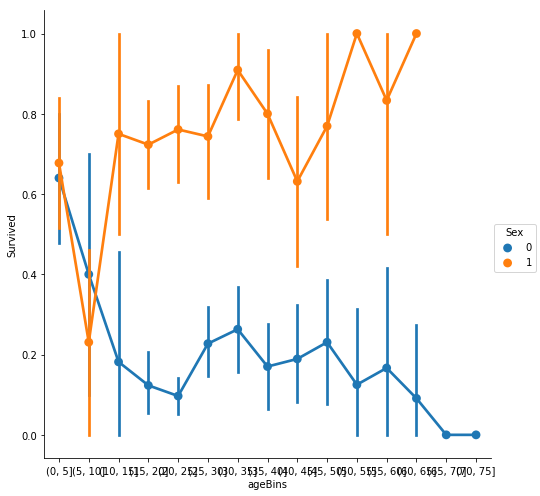

In [53]:
sns.factorplot("ageBins", "Survived", hue="Sex", data=dfFull.loc[1:891,:],size=7)

0 means males  
1 means females  
Till 5 years old the survival rate is similar to women. It in naturally because woman can take small child very easly.  
However around 5-10 something weird is happening. Huge drop on girls event worse than boys.  
Let's check what is the number of such young children:  

In [54]:
dfFull.loc[1:891,:].groupby(['Sex','ageBins']).Name.count()

Sex  ageBins 
0    (0, 5]       25
     (5, 10]      10
     (10, 15]     11
     (15, 20]     73
     (20, 25]    155
     (25, 30]     88
     (30, 35]     57
     (35, 40]     47
     (40, 45]     37
     (45, 50]     26
     (50, 55]     16
     (55, 60]     12
     (60, 65]     11
     (65, 70]      4
     (70, 75]      3
1    (0, 5]       31
     (5, 10]      13
     (10, 15]     12
     (15, 20]     65
     (20, 25]     46
     (25, 30]     39
     (30, 35]     33
     (35, 40]     25
     (40, 45]     19
     (45, 50]     13
     (50, 55]      8
     (55, 60]      6
     (60, 65]      4
Name: Name, dtype: int64

I thought it will be less.  
Let's here assume that above 10 year, everything looks quite normal and the age doesn't play any role in survival.

In [55]:
dfFull.loc[dfFull.Age <11,'Age'] = 0
dfFull.loc[(dfFull.Age >=10),'Age'] = 1
dfFull.Age.value_counts()

1.0    1200
0.0     109
Name: Age, dtype: int64

As always, let's make a prediction:

In [56]:
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat','Age']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat','Age']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)


![Image](https://preview.ibb.co/iZTO9k/dectree_cla_sex_par_emb_tit_age_far.png)


Another good step forward. Age category gave us +0.5%. Only one step from 0.8.

## PART 10: TICKET 

Let's start from checking values in Ticket category:

In [57]:
dfTicket = dfFull.Ticket.value_counts()
dfTicket.head()

CA. 2343        11
CA 2144          8
1601             8
S.O.C. 14879     7
PC 17608         7
Name: Ticket, dtype: int64

We have tickets assigned to more than one person. It means the same ticket may belong to other family members.
Let's make a category, based on ticket occurrences. I hope it will support Parch category.

In [58]:
lstTicket = dfTicket.loc[dfTicket > 1].index.tolist()
lstTicketSingle = dfTicket.loc[dfTicket == 1].index.tolist()

In [59]:
len(lstTicket)

216

In [60]:
len(lstTicketSingle)

713

We have 713 single tickets and 216 that belong to family members. Based on ticket we can easly identify family members. For example:

In [61]:
dfFull[dfFull.Ticket=='347082'].Name

14                           Andersson, Mr. Anders Johan
120                    Andersson, Miss. Ellis Anna Maria
542                 Andersson, Miss. Ingeborg Constanzia
543                    Andersson, Miss. Sigrid Elisabeth
611    Andersson, Mrs. Anders Johan (Alfrida Konstant...
814                   Andersson, Miss. Ebba Iris Alfrida
851              Andersson, Master. Sigvard Harald Elias
Name: Name, dtype: object

Now, it is time to update ticket number with new category:

In [62]:
dfFull['TicketCat'] = dfFull['Ticket'].copy()

In [63]:
i=1
for ticket in lstTicket:
    dfFull.loc[dfFull.Ticket == ticket, 'TicketCat'] = i
    i+=1

In [64]:
for ticket in lstTicketSingle:
    dfFull.loc[dfFull.Ticket == ticket, 'TicketCat'] = 0

Let's predict the result:

In [65]:
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat','Age','TicketCat']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat','Age','TicketCat']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](https://preview.ibb.co/nFyVN5/sex_par_emb_far_tit_age_tic.png)


Well, well, well. Eventually we acheived our target;-) We have 80.383% and still plain dtree algoritm. Let's go further...:-)

# MISC

Before we start tweaking the classifier, I would like to check one thing.  
In other kernels I saw that some people add name lenght as category. Let's check if it is something worth:

In [66]:
dfFull['NameLen'] = dfFull['Name'].apply(len)
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat','Age','TicketCat','NameLen']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','Embarked','Fare','TitleCat','Age','TicketCat','NameLen']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](https://preview.ibb.co/jdKfcF/NameLen.png)

The result doesn't require commenting...

Let's make a quick summary:

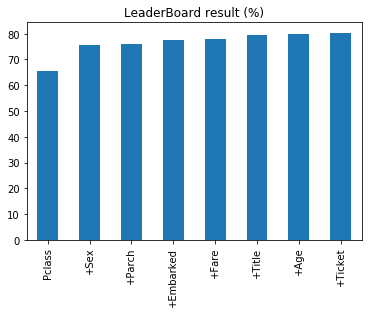

In [67]:
dfResult = pd.Series({'Pclass':65.55,
                      '+Sex':75.59,
                      '+Parch':76.07,
                      '+Embarked':77.51,
                      '+Fare':77.99,
                      '+Title':79.42,
                      '+Age':79.90,
                      '+Ticket':80.38})
dfResult.sort_values().plot(kind='bar',title='LeaderBoard result (%)')

# PART 11: SELECTING THE CLASSIFIER

We will start from testing number of classifiers to choose the best one for further fitting.  
As the first step let's split our Train data into new train/test set:

In [68]:
from sklearn.model_selection import train_test_split
X_train = dfTrain[['Pclass','Sex','ParchCat','SibSpCat','Embarked','Fare','TitleCat','Age','TicketCat']]
X_test = dfTest[['Pclass','Sex','ParchCat','SibSpCat','Embarked','Fare','TitleCat','Age','TicketCat']]
y = dfTrain['Survived']
X_NewTrain, X_NewTest,y_NewTrain, y_NewTest = train_test_split(X_train, y,
                                         test_size=0.33, # 1/3 test; 2/3 train
                                          random_state=1410) # seed

and feed a list of classifiers to find the best score:

In [69]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression(),
    LinearSVC()]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_NewTrain, y_NewTrain)
    prediction = clf.predict(X_NewTest)
    rank = pd.DataFrame(data=np.column_stack([prediction, y_NewTest]),
                                index=X_NewTest.index.values,columns=['Predicted','Real'])
    accurracy = np.sum(rank.Predicted.values == rank.Real.values)
    accurracy = accurracy/len(y_NewTest)
    print(accurracy, name)

0.718644067797 KNeighborsClassifier
0.786440677966 SVC
0.830508474576 DecisionTreeClassifier
0.827118644068 RandomForestClassifier
0.827118644068 AdaBoostClassifier
0.806779661017 GradientBoostingClassifier
0.749152542373 GaussianNB
0.813559322034 LogisticRegression
0.694915254237 LinearSVC


Hmm, interesting results. TOP3 is as follows:  
1. GradientBoostingClassifier ~0.82 
2. RandomForestClassifier ~0.81
3. DecisionTreeClassifier ~0.81

# 12. CONFIRMING SCORE IN KAGGLE SYSTEM

### GradientBoostingClassifier: Your submission scored 0.78469  
### RandomForestClassifier: Your submission scored 0.75598  

The score for other two classifiers is dissapointing, so our first choice using DecisionTree algorithm was right.

# APPENDIX

Thanks to Mykhailo Matviiv, who posted a question in comments, why I dropped categories that didn't bring me better result, I decided to run a kernel again adding those two categories: Cabin and SibSp. I don't want to boring you about not satisfied results and I am presententing only the success story adding only SibSp...

 

In [70]:
dfTrain = dfFull.loc[1:891,:]
dfTest = dfFull.loc[892:,:]
dtree = DecisionTreeClassifier()
X_train = dfTrain[['Pclass','Sex','ParchCat','SibSpCat','Embarked','Fare','TitleCat','Age','TicketCat','CabinCat']]
y = dfTrain['Survived']
X_test = dfTest[['Pclass','Sex','ParchCat','SibSpCat','Embarked','Fare','TitleCat','Age','TicketCat','CabinCat']]
dtree.fit(X_train,y)
prediction = dtree.predict(X_test)
dfPrediction = pd.DataFrame(data=prediction,index = dfTest.index.values,columns=['Survived'])
contentTestPredObject1 = dfPrediction.to_csv()
#print(contentTestPredObject1)

![Image](https://preview.ibb.co/d55ynQ/sex_par_sib_emb_far_tit_age_tic.png)

### 0.818181!
Concluding, adding the category previously refused could give positive effect at the end.
Great tip Mykhailo. I will remeber that rule...